In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.applications import MobileNetV2
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
DATA_PATH = r"C:\Users\Shash\Downloads\brainmri"

In [4]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU Available: {len(gpus)} device(s)")
    print("  Training will be FAST!")
else:
    print("⚠ No GPU found. Training will be SLOWER on CPU.")
    print("  Consider using Google Colab for faster training.")

⚠ No GPU found. Training will be SLOWER on CPU.
  Consider using Google Colab for faster training.


In [6]:
BATCH_SIZE = 32  # Reduce to 16 if running out of memory
EPOCHS = 30

# Output directories
BASE_DIR = './brain_tumor_organized/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

print("\n" + "="*60)
print("CHECKING DATASET")
print("="*60)

if not os.path.exists(DATA_PATH):
    print(f"❌ ERROR: Dataset not found at {DATA_PATH}")
    print("\nPlease either:")
    print("1. Update DATA_PATH in this script to your dataset location")
    print("2. Or uncomment the kagglehub download code above")
    exit(1)

print(f"✓ Dataset found at: {DATA_PATH}")


CHECKING DATASET
✓ Dataset found at: C:\Users\Shash\Downloads\brainmri


In [7]:

print("\n" + "="*60)
print("ORGANIZING DATASET")
print("="*60)

# Clean up old organized data
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

for directory in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(directory, exist_ok=True)

# Find Training and Testing folders
ORIGINAL_TRAIN = os.path.join(DATA_PATH, 'Training')
ORIGINAL_TEST = os.path.join(DATA_PATH, 'Testing')

# If dataset structure is different, try to find data
if not os.path.exists(ORIGINAL_TRAIN):
    print("Looking for alternative dataset structure...")
    for root, dirs, files in os.walk(DATA_PATH):
        if 'Training' in dirs:
            ORIGINAL_TRAIN = os.path.join(root, 'Training')
            ORIGINAL_TEST = os.path.join(root, 'Testing')
            break

def collect_all_images(source_dir):
    """Collect all images organized by class"""
    class_images = {}
    
    if not os.path.exists(source_dir):
        print(f"⚠ Warning: {source_dir} not found")
        return class_images
    
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            if images:
                class_images[class_name] = images
                print(f"  {class_name}: {len(images)} images")
    
    return class_images

print("\nScanning Training folder:")
train_imgs = collect_all_images(ORIGINAL_TRAIN)

print("\nScanning Testing folder:")
test_imgs = collect_all_images(ORIGINAL_TEST)

# Combine all data
all_images = {}
for class_name in set(list(train_imgs.keys()) + list(test_imgs.keys())):
    all_images[class_name] = train_imgs.get(class_name, []) + test_imgs.get(class_name, [])

if not all_images:
    print("\n❌ ERROR: No images found!")
    print("Please check your dataset structure.")
    exit(1)

print("\n" + "="*60)
print("CREATING TRAIN/VAL/TEST SPLIT (70-15-15)")
print("="*60)

for class_name, image_paths in all_images.items():
    random.shuffle(image_paths)
    
    n_total = len(image_paths)
    n_train = int(n_total * 0.7)
    n_val = int(n_total * 0.15)
    
    train_files = image_paths[:n_train]
    val_files = image_paths[n_train:n_train + n_val]
    test_files = image_paths[n_train + n_val:]
    
    # Create directories and copy files
    for split_dir, files in [(TRAIN_DIR, train_files), (VAL_DIR, val_files), (TEST_DIR, test_files)]:
        class_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        
        for i, src in enumerate(files):
            dst = os.path.join(class_dir, f"{class_name}_{i}.jpg")
            shutil.copy(src, dst)
    
    print(f"{class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")



ORGANIZING DATASET

Scanning Training folder:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images

Scanning Testing folder:
  glioma: 300 images
  meningioma: 306 images
  notumor: 405 images
  pituitary: 300 images

CREATING TRAIN/VAL/TEST SPLIT (70-15-15)
notumor: Train=1400, Val=300, Test=300
glioma: Train=1134, Val=243, Test=244
meningioma: Train=1151, Val=246, Test=248
pituitary: Train=1229, Val=263, Test=265


In [10]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("\n" + "="*60)
print("CREATING DATA GENERATORS")
print("="*60)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

num_classes = len(all_images.keys())
class_mode = 'binary' if num_classes == 2 else 'categorical'
print(f"Number of classes: {num_classes}")
print(f"Classification mode: {class_mode}")

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=class_mode,
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=class_mode,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=class_mode,
    shuffle=False
)

print(f"\nTraining samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Test samples: {test_gen.samples}")
print(f"Class indices: {train_gen.class_indices}")

# Calculate class weights
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, c))) 
                for c in sorted(train_gen.class_indices.keys())]
total = sum(class_counts)
class_weight = {i: total/(len(class_counts)*count) for i, count in enumerate(class_counts)}
print(f"Class weights: {class_weight}")



CREATING DATA GENERATORS
Number of classes: 4
Classification mode: categorical
Found 4914 images belonging to 4 classes.
Found 1052 images belonging to 4 classes.
Found 1057 images belonging to 4 classes.

Training samples: 4914
Validation samples: 1052
Test samples: 1057
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class weights: {0: 1.0833333333333333, 1: 1.0673327541268463, 2: 0.8775, 3: 0.999593165174939}


In [11]:
print("\n" + "="*60)
print("BUILDING MODEL (MobileNetV2)")
print("="*60)

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

output_units = 1 if num_classes == 2 else num_classes
output_activation = 'sigmoid' if num_classes == 2 else 'softmax'
loss = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(output_units, activation=output_activation)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss,
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print(f"Total parameters: {model.count_params():,}")

# ============================================================================
# TRAIN MODEL
# ============================================================================

print("\n" + "="*60)
print("TRAINING - PHASE 1 (Frozen Base)")
print("="*60)

checkpoint = callbacks.ModelCheckpoint(
    'best_brain_tumor_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history1 = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

print("\n" + "="*60)
print("TRAINING - PHASE 2 (Fine-tuning)")
print("="*60)


BUILDING MODEL (MobileNetV2)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step
Total parameters: 2,586,948

TRAINING - PHASE 1 (Frozen Base)


c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.6580 - loss: 0.9157 - precision: 0.6959 - recall: 0.6039
Epoch 1: val_accuracy improved from -inf to 0.80038, saving model to best_brain_tumor_model.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6585 - loss: 0.9144 - precision: 0.6963 - recall: 0.6045 - val_accuracy: 0.8004 - val_loss: 0.5113 - val_precision: 0.8310 - val_recall: 0.7757 - learning_rate: 0.0010
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8090 - loss: 0.4998 - precision: 0.8364 - recall: 0.7763
Epoch 2: val_accuracy improved from 0.80038 to 0.82890, saving model to best_brain_tumor_model.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 86s 556ms/step - accuracy: 0.8091 - loss: 0.4998 - precision: 0.8363 - recall: 0.7763 - val_accuracy: 0.8289 - val_loss: 0.4423 - val_precision: 0.8513 - val_recall: 0.8051 - learning_rate: 0.0010
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8238 - loss: 0.4717 - precision: 

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=loss,
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

history2 = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# ============================================================================
# EVALUATE MODEL
# ============================================================================

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

model = tf.keras.models.load_model('best_brain_tumor_model.keras')

train_results = model.evaluate(train_gen, verbose=0)
val_results = model.evaluate(val_gen, verbose=0)
test_results = model.evaluate(test_gen, verbose=0)

print(f"\nTRAIN SET:")
print(f"  Accuracy:  {train_results[1]*100:.2f}%")
print(f"  Precision: {train_results[2]*100:.2f}%")
print(f"  Recall:    {train_results[3]*100:.2f}%")

print(f"\nVALIDATION SET:")
print(f"  Accuracy:  {val_results[1]*100:.2f}%")
print(f"  Precision: {val_results[2]*100:.2f}%")
print(f"  Recall:    {val_results[3]*100:.2f}%")

print(f"\nTEST SET:")
print(f"  Accuracy:  {test_results[1]*100:.2f}%")
print(f"  Precision: {test_results[2]*100:.2f}%")
print(f"  Recall:    {test_results[3]*100:.2f}%")

# Predictions and confusion matrix
test_gen.reset()
preds = model.predict(test_gen, verbose=0)

if num_classes == 2:
    pred_classes = (preds > 0.5).astype(int).flatten()
else:
    pred_classes = np.argmax(preds, axis=1)

true_classes = test_gen.classes[:len(pred_classes)]

cm = confusion_matrix(true_classes, pred_classes)
print("\nConfusion Matrix:")
print(cm)

class_names = list(train_gen.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_names))

Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8016 - loss: 0.6599 - precision: 0.8175 - recall: 0.7822
Epoch 1: val_accuracy improved from 0.85266 to 0.88213, saving model to best_brain_tumor_model.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 141s 869ms/step - accuracy: 0.8019 - loss: 0.6585 - precision: 0.8178 - recall: 0.7826 - val_accuracy: 0.8821 - val_loss: 0.3303 - val_precision: 0.8874 - val_recall: 0.8764 - learning_rate: 1.0000e-04
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8967 - loss: 0.2754 - precision: 0.9093 - recall: 0.8881
Epoch 2: val_accuracy improved from 0.88213 to 0.89354, saving model to best_brain_tumor_model.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 100s 648ms/step - accuracy: 0.8968 - loss: 0.2754 - precision: 0.9094 - recall: 0.8881 - val_accuracy: 0.8935 - val_loss: 0.3291 - val_precision: 0.9021 - val_recall: 0.8850 - learning_rate: 1.0000e-04
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.9114 - loss: 0.226


PLOTTING TRAINING HISTORY


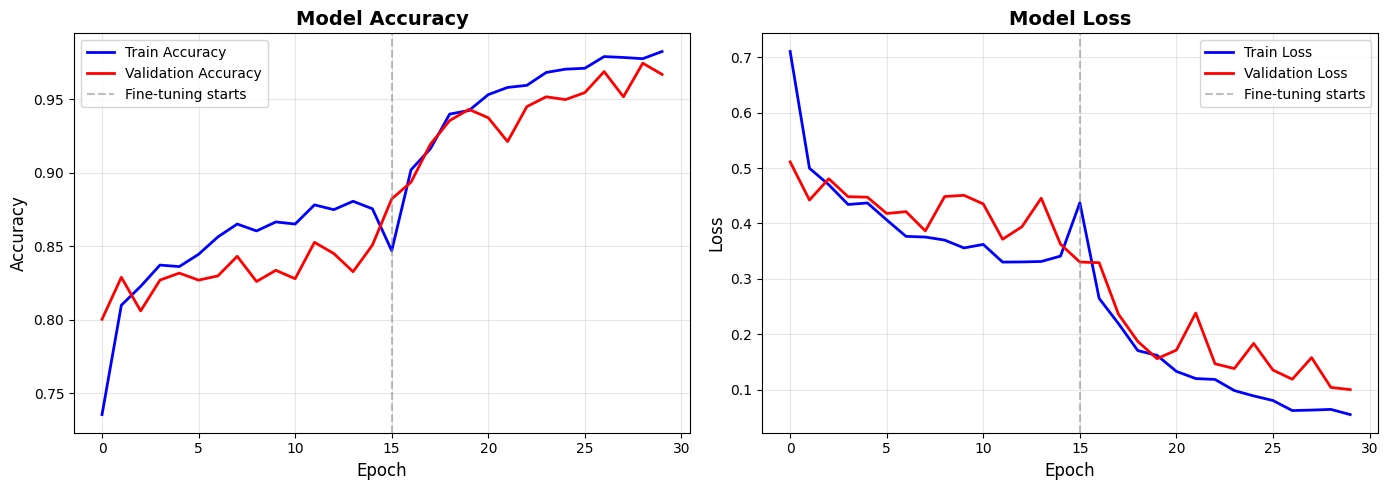


TRAINING COMPLETE!
✓ Best model saved: best_brain_tumor_model.keras
✓ Training plot saved: training_history.png
✓ Test Accuracy: 96.50%


In [ ]:
print("\n" + "="*60)
print("PLOTTING TRAINING HISTORY")
print("="*60)

all_acc = history1.history['accuracy'] + history2.history['accuracy']
all_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
all_loss = history1.history['loss'] + history2.history['loss']
all_val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(all_acc, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(all_val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(len(history1.history['accuracy']), color='gray', 
            linestyle='--', alpha=0.5, label='Fine-tuning starts')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(all_loss, 'b-', label='Train Loss', linewidth=2)
plt.plot(all_val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.axvline(len(history1.history['loss']), color='gray', 
            linestyle='--', alpha=0.5, label='Fine-tuning starts')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Save training history and evaluation metrics to disk for dashboard use ---
import json
history_dict = {
    'accuracy': all_acc,
    'val_accuracy': all_val_acc,
    'loss': all_loss,
    'val_loss': all_val_loss
}
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)

# Save final evaluation metrics (train/val/test) as JSON
metrics = {
    'train': {
        'accuracy': float(train_results[1]),
        'precision': float(train_results[2]),
        'recall': float(train_results[3])
    },
    'val': {
        'accuracy': float(val_results[1]),
        'precision': float(val_results[2]),
        'recall': float(val_results[3])
    },
    'test': {
        'accuracy': float(test_results[1]),
        'precision': float(test_results[2]),
        'recall': float(test_results[3])
    }
}
with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f)

print("\nSaved training history to training_history.json and metrics to model_metrics.json")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"✓ Best model saved: best_brain_tumor_model.keras")
print(f"✓ Training plot saved: training_history.png")
print(f"✓ Test Accuracy: {test_results[1]*100:.2f}%")